In [ ]:
# Theses are different ways to display figures, depending on the
# environment, some may work better or some not at all:
%matplotlib inline
# %matplotlib notebook
# %matplotlib ipympl
# %matplotlib widget
#      widget (installed by ``pip install ipympl``) gives dynamic inline plots
# %matplotlib nbagg
# Fix failing variable completion (for older installations):
# %config Completer.use_jedi = False

# First, Simplest Usecase

Let's optimize a simple ellipsoid function, $\sum_{i=1}^n 1000^{\frac{i-1}{n-1}}x_i^2$, whose Hessian has a condition number of $10^6$:

In [ ]:
# pip install cma  # outcomment in case the cma module is not installed
import cma

fun = cma.ff.elli  # we could use `functools.partial(cma.ff.elli, cond=1e4)` to change the condition number to 1e4
x0 = 4 * [2]  # initial solution
sigma0 = 1    # initial standard deviation to sample new solutions

x, es = cma.fmin2(fun, x0, sigma0)

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=653161, Mon Mar 10 13:51:37 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.655852706219656e+06 1.0e+00 1.03e+00  1e+00  1e+00 0:00.0
    2     16 1.741837807321757e+05 1.5e+00 1.21e+00  1e+00  1e+00 0:00.0
    3     24 1.923939903372240e+05 1.9e+00 1.14e+00  1e+00  1e+00 0:00.0
  100    800 3.614917210617235e-04 1.0e+03 8.38e-03  8e-06  1e-02 0:00.0
  185   1480 2.158166353246992e-15 1.3e+03 8.76e-07  3e-11  4e-08 0:00.1
termination on tolfun=1e-11 (Mon Mar 10 13:51:37 2025)
final/bestever f-value = 1.242615e-15 1.242615e-15 after 1481/1481 evaluations
incumbent solution: [6.492115485249592e-09, -3.3548503398127476e-10, -1.3269297893407394e-10, -3.182983806700709e-11]
std deviation: [3.741916960413404e-08, 2.3536193050592146e-09, 2.2412477949371293e-10, 3.361962100065927e-11]


The return values are
- `x`, the best evaluated solution and
- `es`, the `cma.CMAEvolutionStrategy` class instance used to run the optimization.

The latter contains all available information about the run and the more complete return value under `es.result`.

In [3]:
dict(es.result._asdict())  # pretty print the named tuple as dictionary

{'xbest': array([ 6.49211549e-09, -3.35485034e-10, -1.32692979e-10, -3.18298381e-11]),
 'fbest': 1.2426154422322386e-15,
 'evals_best': 1481,
 'evaluations': 1481,
 'iterations': 185,
 'xfavorite': array([ 6.49211549e-09, -3.35485034e-10, -1.32692979e-10, -3.18298381e-11]),
 'stds': array([3.74191696e-08, 2.35361931e-09, 2.24124779e-10, 3.36196210e-11]),
 'stop': {'tolfun': 1e-11}}

In [4]:
es.result_pretty()  # shows some pretty information and returns es.result

termination on tolfun=1e-11
final/bestever f-value = 1.242615e-15 1.242615e-15 after 1481/1481 evaluations
incumbent solution: [6.492115485249592e-09, -3.3548503398127476e-10, -1.3269297893407394e-10, -3.182983806700709e-11]
std deviation: [3.741916960413404e-08, 2.3536193050592146e-09, 2.2412477949371293e-10, 3.361962100065927e-11]


CMAEvolutionStrategyResult(xbest=array([ 6.49211549e-09, -3.35485034e-10, -1.32692979e-10, -3.18298381e-11]), fbest=1.2426154422322386e-15, evals_best=1481, evaluations=1481, iterations=185, xfavorite=array([ 6.49211549e-09, -3.35485034e-10, -1.32692979e-10, -3.18298381e-11]), stds=array([3.74191696e-08, 2.35361931e-09, 2.24124779e-10, 3.36196210e-11]), stop={'tolfun': 1e-11})

# Options
Options can be passed as fourth parameter to `cma.fmin2`. Valid options are

In [ ]:
cma.CMAOptions()  # as of cma.__version__ == '4.0.0'

{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA',
 'CMA_active': 'True  # negative update, conducted after the original update',
 'CMA_active_injected': '0  #v weight multiplier for negative weights of injected solutions',
 'CMA_cmean': '1  # learning rate for the mean value',
 'CMA_const_trace': 'False  # normalize trace, 1, True, "arithm", "geom", "aeig", "geig" are valid',
 'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_diagonal_decoding': '0  # learning rate multiplier for additional diagonal update',
 'CMA_eigenmethod': 'np.linalg.eigh  # or cma.utilities.math.eig or pygsl.eigen.eigenvectors',
 'CMA_elitist': 'False  #v or "initial" or True, elitism likely impairs global search performance',
 'CMA_injections_threshold_keep_len': '1  #v keep length if Mahalanobis length is below the given relative threshold',
 'CMA_mirrors': 'popsize < 6  # values <0.5 are int

A `#v` indicates versatile options that can be changed at any time during the run by changing the `opts` attribute of the underlying [`CMAEvolutionStrategy`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.CMAEvolutionStrategy.html) class instance.

To run the code entirely quietly, for example for benchmarking or in final production runs when the desired behavior is established, use `{'verbose':-9'}`.

# Options and Plotting
Let's plot some data from the optimization. The above call to `cma.fmin2` has (by default) written data to the default output folder `outcmaes`. These data will be overwritten each time the function is called again. To prevent this, we could set/change the output folder with the `verb_filenameprefix` option. An effective way to find out this kind of behavior is to query the [`CMAOptions`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.CMAOptions.html) with a search string and read the comments in the return "value".

In [6]:
cma.CMAOptions('file')

{'signals_filename': 'cma_signals.in  # read versatile options from this file (use `None` or `""` for no file) which contains a single options dict, e.g. ``{"timeout": 0}`` to stop, string-values are evaluated, e.g. "np.inf" is valid',
 'verb_append': '0  # initial evaluation counter, if append, do not overwrite output files',
 'verb_filenameprefix': 'outcmaes/  # output path (folder) and filenames prefix',
 'verb_log': '1  #v verbosity: write data to files every verb_log iteration, writing can be time critical on fast to evaluate functions'}

Plotting is as simple as

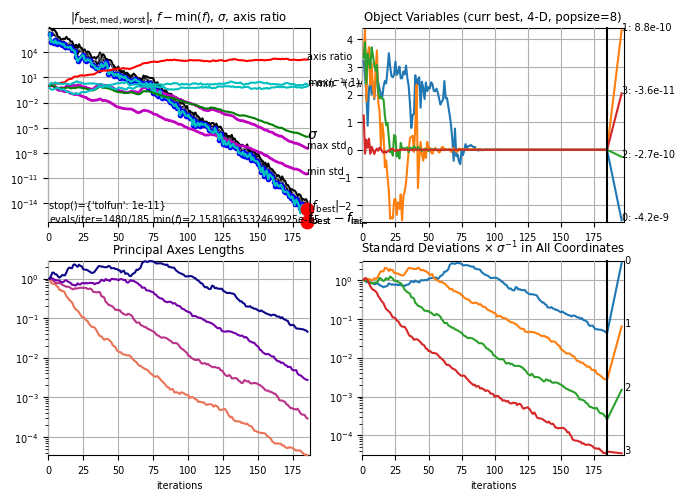

In [7]:
es.plot();  # cma.plot() does the same, as we just plot the data from the default output folder

A description of the output is given in the caption of Figure 3 in [Hansen et al (2015): Evolution Strategies](https://hal.inria.fr/hal-01155533/file/es-overview-2015.pdf#page=17).

# Options and Bound Constraints
We can add a boundary condition on any variable. We can find out how to do this, as mentioned above, by investigating the available boundary related options:

In [8]:
cma.CMAOptions('bound')  # returns options that contain "bound"

{'BoundaryHandler': 'BoundTransform  # or BoundPenalty, unused when ``bounds in (None, [None, None])``',
 'bounds': '[None, None]  # lower (=bounds[0]) and upper domain boundaries, each a scalar or a list/vector',
 'maxstd_boundrange': '1/3  # maximal std relative to bound_range per coordinate, overruled by maxstd'}

Let's bound the second variable from below to values $\ge1$ using the `'bounds'` option. In this case, we must also take care that the initial solution is within the given bounds (it is, in our case). `'bounds'` is a list of two values, `[lower_bounds, upper_bounds]`, where `lower_bounds` and `upper_bounds` can be a scalar that applies to all variables or a list. If the list is shorter than the initial solution, the last value is applied to the remaining dimensions.

In [9]:
xopt_b, es_b = cma.fmin2(fun, x0, sigma0, {'bounds': [[None, 1, None], None]})

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=654294, Mon Mar 10 13:51:38 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 2.325102524210271e+06 1.0e+00 1.07e+00  1e+00  1e+00 0:00.0
    2     16 1.927618038212036e+04 1.4e+00 1.39e+00  1e+00  2e+00 0:00.0
    3     24 2.131349153459862e+04 1.6e+00 1.48e+00  1e+00  2e+00 0:00.0
  100    800 1.000342823940897e+02 9.2e+02 7.13e-02  1e-04  1e-01 0:00.1
  200   1600 9.999999999999997e+01 1.2e+03 1.99e-06  6e-11  8e-08 0:00.1
  203   1624 9.999999999999997e+01 1.5e+03 1.66e-06  4e-11  6e-08 0:00.1
termination on tolfun=1e-11 (Mon Mar 10 13:51:38 2025)
final/bestever f-value = 1.000000e+02 1.000000e+02 after 1625/1571 evaluations
incumbent solution: [-3.125203532244545e-08, 1.0, -5.304676713241154e-10, 3.6078700300111407e-11]
std deviation: [6.105144307738443e-08, 1.5451151329109097e-09, 5.689138634804834e-10, 4.224943590874883e-11]


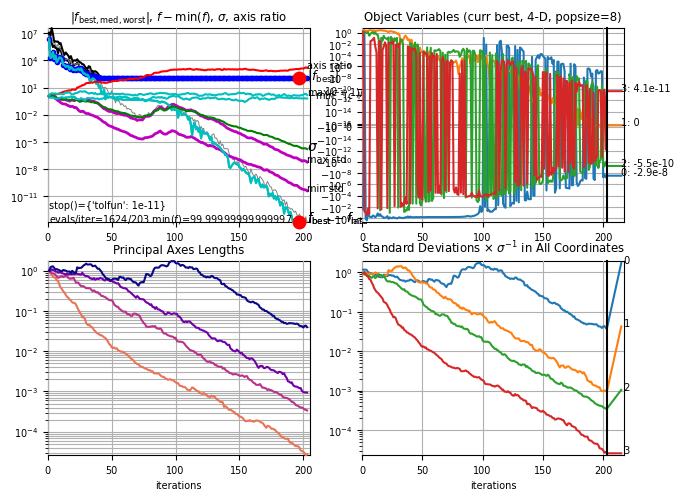

In [10]:
es.plot(xsemilog=True, x_opt=[0, 1] + (len(x0) - 2) * [0]);

### Rescaling of the Objective
In a practical application, the encoding of variables is often essential to turn a _very_ difficult problem into less difficult one, see also [here](https://cma-es.github.io/cmaes_sourcecode_page.html#practical). The simplest encoding is a rescaling, which can easily be done via the [`cma.ScaleCoordinates`](https://cma-es.github.io/apidocs-pycma/cma.fitness_transformations.ScaleCoordinates.html) class. Again, the [`CMAOptions`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.CMAOptions.html) give the hint where to look.

In [11]:
cma.CMAOptions('scale')

{'CMA_stds': 'None  # multipliers for sigma0 in each coordinate (not represented in C), or use `cma.ScaleCoordinates` instead',
 'scaling_of_variables': 'None  # deprecated, rather use fitness_transformations.ScaleCoordinates instead (or CMA_stds). WAS: Scale for each variable in that effective_sigma0 = sigma0*scaling. Internally the variables are divided by scaling_of_variables and sigma is unchanged, default is `np.ones(N)`'}

We rescale the ellipsoid function to its most benign form. In dimension 4, this saves only about 30% of the necessary iterations.

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=693197, Mon Mar 10 13:51:39 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.902150709898359e+00 1.0e+00 1.12e+00  1e+00  1e+00 0:00.0
    2     16 2.032059735041583e+00 1.4e+00 1.26e+00  1e+00  1e+00 0:00.0
    3     24 5.274463068265427e-01 1.6e+00 1.36e+00  1e+00  1e+00 0:00.0
  100    800 1.065870672749775e-12 2.0e+00 4.68e-05  7e-07  1e-06 0:00.1
  120    960 1.361947839940894e-15 2.0e+00 4.21e-06  3e-08  4e-08 0:00.1
termination on tolfun=1e-11 (Mon Mar 10 13:51:39 2025)
final/bestever f-value = 8.002946e-16 8.002946e-16 after 961/961 evaluations
incumbent solution: [-6.8428032022839836e-09, -1.8657378698094788e-08, 1.1626493822055345e-08, 1.6437685265523465e-08]
std deviation: [2.680888520767427e-08, 3.657807208339234e-08, 3.526454652853033e-08, 2.9245381715788174e-08]


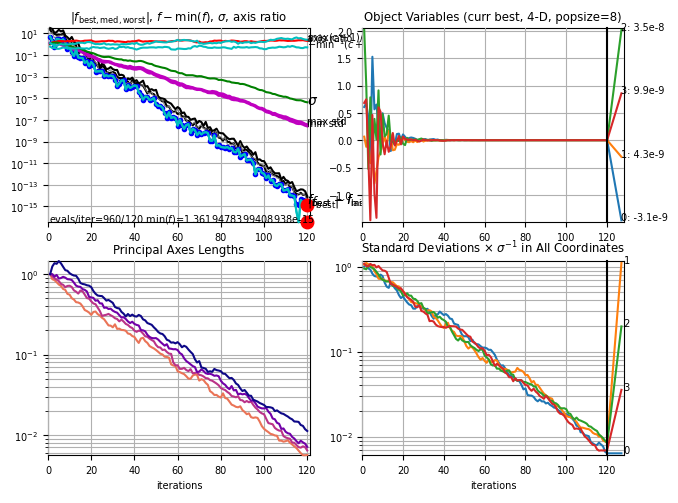

In [12]:
fun2 = cma.ScaleCoordinates(fun, [1000**(-i / 3) for i in range(4)])
xopt2, es2 = cma.fmin2(fun2, x0, sigma0)
cma.plot();


On the 40-dimension ellipsoid function, the saving is much more substantial, namely a factor of about 6 to 7:

In [13]:
xopt40, es40 = cma.fmin2(fun, 40 * [2], sigma0, {'verbose':-9})
xopt0, es0 = cma.fmin2(cma.ScaleCoordinates(fun,
                                            [1000**(-i / 39) for i in range(40)]),
                       40 * [2], sigma0, {'verbose':-9})

In [14]:
es40.result.fbest, es0.result.fbest, es40.result.evals_best / es0.result.evals_best

(2.648583558990952e-14, 1.299586322580117e-14, 6.548420241459029)

Without covariance matrix adaptation, the saving from rescaling would be even _much_ more substantial, namely a factor of about $10\,000$, which can be inferred from Figure 10 in [Hansen and Ostermeier (2001)](http://www.cmap.polytechnique.fr/~nikolaus.hansen/publications.html#hansenaost2001).

### Advanced Options Settings
#### Setting the step-size adaptation
Apart from the default cumulative step-size adaptation, another competitive way to adapt the step-size is the two-point step-size adaptation, TPA, see Equations (6)-(8) in [Akimoto and Hansen (2016)](https://hal.inria.fr/hal-01306551).

In [15]:
cma.CMAOptions('sigma')

{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA',
 'CMA_dampsvec_fac': 'np.inf  # tentative and subject to changes, 0.5 would be a "default" damping for sigma vector update',
 'CMA_dampsvec_fade': '0.1  # tentative fading out parameter for sigma vector update',
 'CMA_stds': 'None  # multipliers for sigma0 in each coordinate (not represented in C), or use `cma.ScaleCoordinates` instead',
 'CSA_squared': 'False  #v use squared length for sigma-adaptation ',
 'scaling_of_variables': 'None  # deprecated, rather use fitness_transformations.ScaleCoordinates instead (or CMA_stds). WAS: Scale for each variable in that effective_sigma0 = sigma0*scaling. Internally the variables are divided by scaling_of_variables and sigma is unchanged, default is `np.ones(N)`',
 'stall_sigma_change_on_divergence_iterations': 'False  #v number of iterations of median worsenings threshold at which the sigma change is stalled; the default may become 2',
 'to

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=718086, Mon Mar 10 13:51:43 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 9.623846631410287e+05 1.0e+00 9.37e-01  9e-01  9e-01 0:00.0
    2     16 1.232087466790945e+05 1.2e+00 9.76e-01  9e-01  1e+00 0:00.0
    3     24 3.572445640685288e+04 1.5e+00 1.04e+00  9e-01  1e+00 0:00.0
  100    800 2.183274377565867e-01 7.9e+02 2.02e-01  3e-04  3e-01 0:00.1
  200   1600 3.867072817885541e-14 1.0e+03 1.37e-05  3e-10  3e-07 0:00.1
  211   1688 3.568648199818162e-15 7.5e+02 3.40e-06  6e-11  4e-08 0:00.1
termination on tolfun=1e-11 (Mon Mar 10 13:51:44 2025)
final/bestever f-value = 7.217090e-16 7.217090e-16 after 1689/1689 evaluations
incumbent solution: [-1.0234675739698932e-08, -9.184253309757926e-11, 9.88213903438925e-11, 2.2769721412440677e-11]
std deviation: [3.782002916093947e-08, 4.169108536758907e-09, 5.429554405503315e-10, 5.895480661035491e-11]


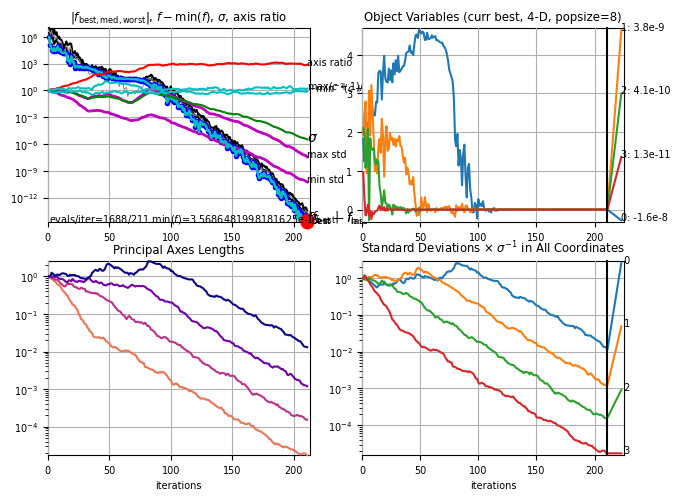

In [16]:
xopt, es = cma.fmin2(fun, x0, sigma0,
                     {'AdaptSigma': cma.sigma_adaptation.CMAAdaptSigmaTPA})
cma.plot();

Without step-size adaptation, the "final" convergence stage of the optimization takes about 3 to 4 times longer (and the effect would become more pronounced in higher dimension):

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=722634, Mon Mar 10 13:51:44 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.241203095209288e+06 1.0e+00 1.00e+00  1e+00  1e+00 0:00.0
    2     16 1.509523996078712e+05 1.2e+00 1.00e+00  9e-01  1e+00 0:00.0
    3     24 4.883813567487130e+04 1.3e+00 1.00e+00  8e-01  1e+00 0:00.0
  100    800 7.634431623854545e-01 1.1e+03 1.00e+00  5e-04  5e-01 0:00.1
  200   1600 3.988522606408935e-05 1.2e+03 1.00e+00  5e-06  5e-03 0:00.1
  300   2400 3.213160674711155e-09 1.2e+03 1.00e+00  6e-08  6e-05 0:00.1
  396   3168 1.657670552367699e-12 1.3e+03 1.00e+00  8e-10  1e-06 0:00.2
termination on tolfun=1e-11 (Mon Mar 10 13:51:45 2025)
final/bestever f-value = 4.807928e-13 4.807928e-13 after 3169/3169 evaluations
incumbent solution: [-3.137393115229126e-07, 2.571645180591117e-08, -2.0052466292599827e-09, 5.253729318893925e-10]
std deviation: [9.947461712683941e-07, 8.028142959978967e-08, 1.0113205496403

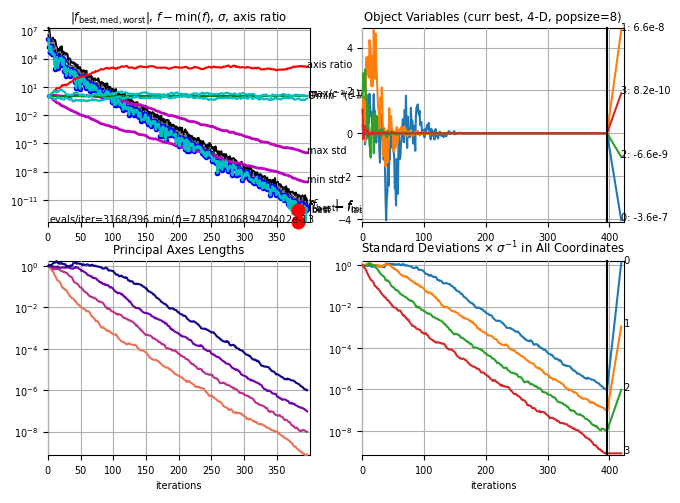

In [17]:
xopt, es = cma.fmin2(fun, x0, sigma0, {'AdaptSigma': False})
cma.plot();

#### Setting different learning rates
A more research related option is the manual setting of learning rates. We can find the relevant options for the covariance matrix update like

In [18]:
cma.CMAOptions('covar')

{'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_on': '1  # multiplier for all covariance matrix updates',
 'CMA_rankmu': '1.0  # multiplier for rank-mu update learning rate of covariance matrix',
 'CMA_rankone': '1.0  # multiplier for rank-one update learning rate of covariance matrix',
 'tolconditioncov': '1e14  #v stop if the condition of the covariance matrix is above `tolconditioncov`'}

If we want to run CMA-ES only with rank-$\mu$ update, we set the learning rate for the rank-one update to zero. Then, to get a solution of the same quality on the 4-dimensional ellipsoid function, it takes on average about 15% more iterations.

In [19]:
xopt, es = cma.fmin2(fun, x0, sigma0, {'CMA_rankone': 0})

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=732819, Mon Mar 10 13:51:45 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.968276438958495e+06 1.0e+00 1.05e+00  1e+00  1e+00 0:00.0
    2     16 3.496898567538401e+05 1.3e+00 1.18e+00  1e+00  1e+00 0:00.0
    3     24 7.213371148301390e+04 1.3e+00 1.19e+00  1e+00  1e+00 0:00.0
  100    800 2.386964583054541e-02 6.3e+02 1.80e-02  1e-04  8e-02 0:00.0
  198   1584 5.811206109475387e-16 1.1e+03 6.38e-08  5e-11  6e-08 0:00.1
termination on tolfun=1e-11 (Mon Mar 10 13:51:45 2025)
final/bestever f-value = 1.685707e-15 5.811206e-16 after 1585/1584 evaluations
incumbent solution: [9.755014211595704e-10, -4.099211469427983e-09, -3.490609089651643e-12, 2.0688755688064317e-12]
std deviation: [6.016519449537516e-08, 5.197511526523419e-09, 4.813263122966796e-10, 5.163431059272194e-11]


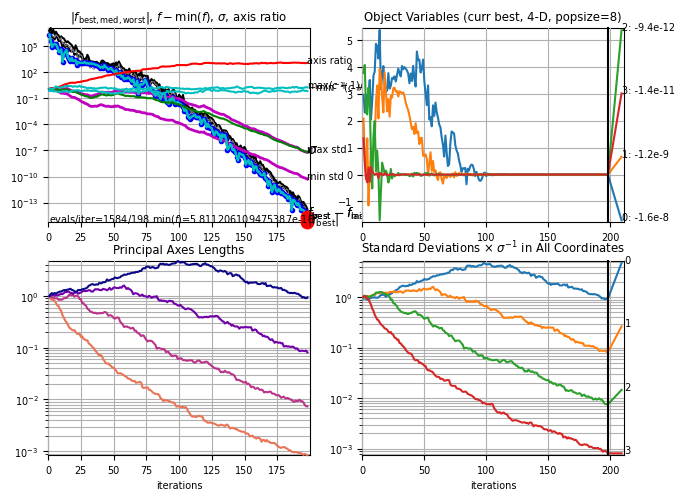

In [20]:
cma.plot();

## See Also

Other [`notebooks and recipes`](https://github.com/CMA-ES/pycma/tree/master/notebooks), as this one, can be found at [https://github.com/CMA-ES/pycma/tree/master/notebooks](https://github.com/CMA-ES/pycma/tree/master/notebooks)

More `notebook-recipes` to come...